# Pytorch workflow fundamentals

https://www.learnpytorch.io/01_pytorch_workflow/

In [105]:
!pip install torch matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [106]:
import torch 
import matplotlib.pyplot as plt


In [107]:
## we will use linear regression to create the data with known parameters

#known parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

len(X), len(y)

(50, 50)

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [109]:
# create training and test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None    ):

    plt.figure(figsize=(10,7))

    #plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    #plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})
    

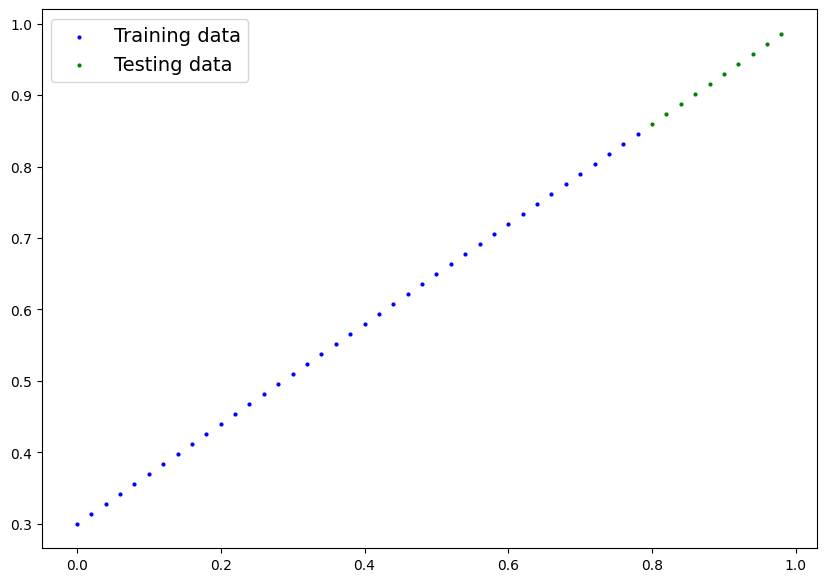

In [111]:
plot_predictions()

In [112]:
## Build model
from torch import nn

# create a linear regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [113]:
from torch.nn.parameter import Parameter


torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

In [114]:
model_0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [115]:
model_0.to(device)

Model device: cuda:0


OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [116]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)


Optimizer device: cuda:0


In [117]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 100

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Track values
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    ### Training
    model_0.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_0.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_0(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Train loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Train loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Train loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Train loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Train loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Train loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Train loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Train loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Train loss: 0.009653178043663502 | Test loss: 0.02167237363755703


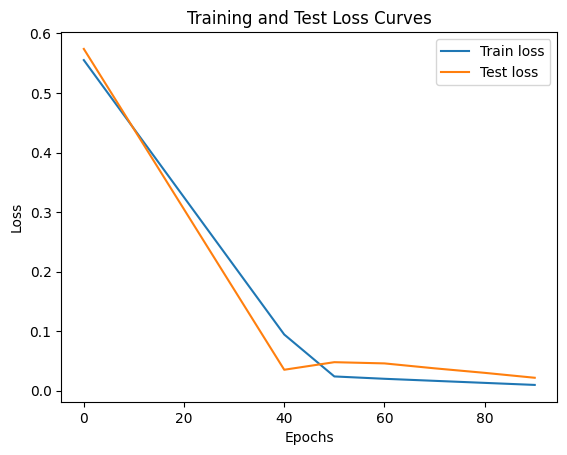

In [118]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [119]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # Model and data are already on the same device (device variable)
  # Verify device consistency
  assert next(model_0.parameters()).device == X_test.device, \
      f"Model device ({next(model_0.parameters()).device}) != Data device ({X_test.device})"
  
  y_preds = model_0(X_test)
y_preds

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]], device='cuda:0')

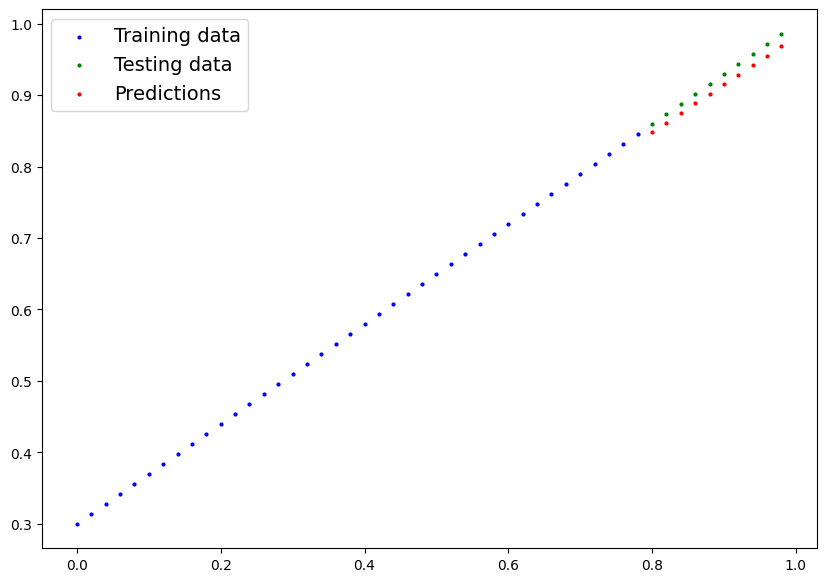

In [120]:
# Convert predictions to CPU numpy for plotting
# plot_predictions function handles device conversion automatically, but we can do it explicitly here too
predictions = y_preds.cpu().detach().numpy() if isinstance(y_preds, torch.Tensor) else y_preds
plot_predictions(predictions=predictions)



In [121]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_0.pth


In [122]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

# Put the loaded model to the right device (must match the device of the data)
loaded_model_0.to(device)

# Verify model is on correct device
print(f"Loaded model device: {next(loaded_model_0.parameters()).device}")

Loaded model device: cuda:0


In [123]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    # Verify device consistency before making predictions
    assert next(loaded_model_0.parameters()).device == X_test.device, \
        f"Loaded model device ({next(loaded_model_0.parameters()).device}) != Data device ({X_test.device})"
    
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model
loaded_model_preds

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]], device='cuda:0')

In [124]:
# Compare previous model predictions with loaded model predictions (these should be the same)
# Both predictions should be on the same device
assert y_preds.device == loaded_model_preds.device, \
    f"Predictions on different devices: y_preds on {y_preds.device}, loaded_model_preds on {loaded_model_preds.device}"

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')